In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# read in csv file and creating an original df which we wont change. dropping certain unnecessary columns and renaming the necessary columns.

csv_file_path = r'..\Data\Raw\GDP_growth\real-gdp-growth.csv'
df_gdp_rate_original = pd.read_csv(csv_file_path)
df_gdp_rate = df_gdp_rate_original.copy()
df_gdp_rate = df_gdp_rate.drop(columns=['Gross domestic product, constant prices - Percent change - Forecasts'])
df_gdp_rate.rename(columns={'Entity': 'country', 'Gross domestic product, constant prices - Percent change - Observations' : 'gdp_change_%', 'Year' : 'year'}, inplace=True)

In [4]:
# read in csv file and creating an original df which we wont change. Setting the literacy year start at 1980 since the Gdp set goes back to 1980.
# Calculating and adding the new column literacy change rate since we aslo meassure the change in gdp.

csv_file_path = r'..\Data\Raw\Literacy\literacy-rate-adults.csv'
df_lit_original= pd.read_csv(csv_file_path)
df_lit = df_lit_original.copy()
df_lit = df_lit[df_lit['Year'] >= 1980]
df_lit = df_lit.drop(columns=['Code'])
df_lit['literacy_change_%'] = df_lit.groupby('Entity')['Literacy rate, adult total (% of people ages 15 and above)'].pct_change() * 100
df_lit.rename(columns={'Entity': 'country', 'Year' : 'year', 'Literacy rate, adult total (% of people ages 15 and above)' : 'literacy_rate_%'}, inplace=True)

In [5]:
# Merging literacy and unemployment data sets on country and year.

merged_df = pd.merge(df_gdp_rate, df_lit, on=['country', 'year'], how='inner')
merged_df.set_index('country', inplace=True)
merged_df.head(10)

,Code,year,gdp_change_%,literacy_rate_%,literacy_change_%
country,,,,,
Afghanistan,AFG,2011,6.479,31.44885,NaN
Afghanistan,AFG,2021,-20.737,37.26604,18.497306
Albania,ALB,2001,8.293,98.71298,NaN
Albania,ALB,2008,7.500,95.93864,-2.810512
Albania,ALB,2011,2.545,96.84530,0.945042
Albania,ALB,2012,1.418,97.24697,0.414754
Albania,ALB,2018,4.019,98.14115,0.919494
Albania,ALB,2021,8.909,98.45000,0.314700
Algeria,DZA,1987,-0.700,49.63088,NaN


In [6]:
#merged_df.to_csv('gdp_literacy.csv', index=False)

In [7]:
# Correlation check between gdp change and literacy change.

correlation = merged_df['gdp_change_%'].corr(merged_df['literacy_change_%'])
print(correlation)

0.05212055806475716


                            OLS Regression Results                            
Dep. Variable:           gdp_change_%   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.321
Date:                Thu, 07 Mar 2024   Prob (F-statistic):              0.128
Time:                        17:38:48   Log-Likelihood:                -2578.2
No. Observations:                 854   AIC:                             5160.
Df Residuals:                     852   BIC:                             5170.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.9910      0.18

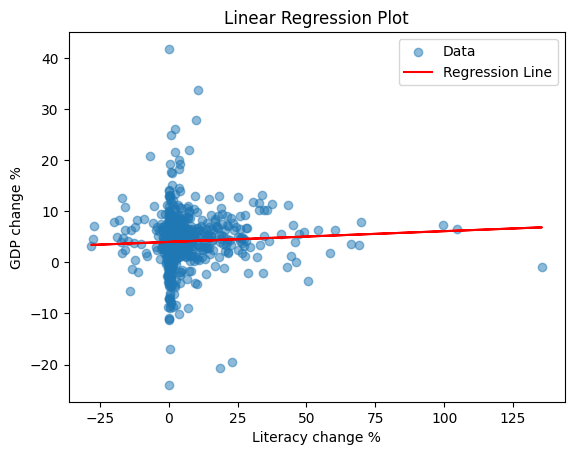

In [8]:
# A more advanced check also giving us the p value and R^2.

missing_values = merged_df.isnull().sum()
df_clean = merged_df.dropna()

X = df_clean['literacy_change_%']
y = df_clean['gdp_change_%']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

plt.scatter(X['literacy_change_%'], y, alpha=0.5, label='Data')
plt.plot(X['literacy_change_%'], model.predict(X), color='red', label='Regression Line')
plt.xlabel('Literacy change %')
plt.ylabel('GDP change %')
plt.title('Linear Regression Plot')

plt.legend()
plt.show()

Overall, the results suggest that there is a statistically significant but weak inverse relationship between GDP change and literacy rate. However, the small R-squared value indicates that the model does not explain much of the variation in literacy rate, and other factors may be at play. 

In [9]:
# Checking for extreme values

merged_df.describe()

,year,gdp_change_%,literacy_rate_%,literacy_change_%
count,995.000000,989.000000,995.000000,860.000000
mean,2008.228141,4.126936,81.557678,4.801725
std,10.349293,6.033041,20.058617,12.252592
min,1980.000000,-23.983000,10.894650,-28.169524
25%,2002.000000,1.846000,72.256835,0.122112
50%,2011.000000,4.035000,90.632990,0.937914
75%,2016.000000,6.454000,96.193020,5.055242
max,2021.000000,110.505000,100.000000,135.475302


                            OLS Regression Results                            
Dep. Variable:           gdp_change_%   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     13.85
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           0.000211
Time:                        17:38:50   Log-Likelihood:                -2261.2
No. Observations:                 818   AIC:                             4526.
Df Residuals:                     816   BIC:                             4536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.7674      0.14

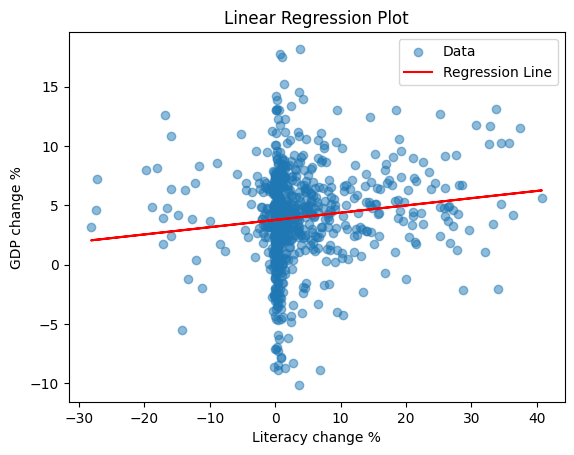

In [10]:
# This time a correlation calculation but without the extreme values. This because extreme values can distort the outcome of a correlation meassurement.
#The extreme's are calculated using the z score and taken out of the df.

df_clean = merged_df.dropna()
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna()

z_scores_gdp = stats.zscore(df_clean['gdp_change_%'])
z_scores_lit = stats.zscore(df_clean['literacy_change_%'])
threshold = 3

merged_df_no_extreme = df_clean[(abs(z_scores_gdp) < threshold) & (abs(z_scores_lit) < threshold)]

X = merged_df_no_extreme['literacy_change_%']
y = merged_df_no_extreme['gdp_change_%']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

plt.scatter(X['literacy_change_%'], y, alpha=0.5, label='Data')
plt.plot(X['literacy_change_%'], model.predict(X), color='red', label='Regression Line')
plt.xlabel('Literacy change %')
plt.ylabel('GDP change %')
plt.title('Linear Regression Plot')
#plt.savefig('gdp_literacy_lrp.png')
plt.legend()
plt.show()

In [11]:
# Correlation without extreme values

correlation = merged_df_no_extreme['gdp_change_%'].corr(merged_df_no_extreme['literacy_change_%'])
print(correlation)

0.12919789847114796
